In [1]:
import pandas as pd

In [2]:
TRAIN_DATASET_FILE = 'data/sales_train.csv.gz'
TEST_DATASET_FILE = 'data/test.csv.gz'
SHOP_INFO_FILE = 'data/shops.csv'
ITEM_INFO_FILE = 'data/items.csv'
ITEM_CAT_INFO_FILE = 'data/item_categories.csv'
SAMPLE_SUB_FILE ='data/sample_submission.csv.gz'

## Recall of the data field meaning
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd.mm.yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., -October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category


### Quick look at the train dataset

In [3]:
raw_train_dataset = pd.read_csv(TRAIN_DATASET_FILE)
print(raw_train_dataset.shape)
raw_train_dataset.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
df = raw_train_dataset[(raw_train_dataset.shop_id == 31) & (raw_train_dataset.item_cnt_day > 0)] 

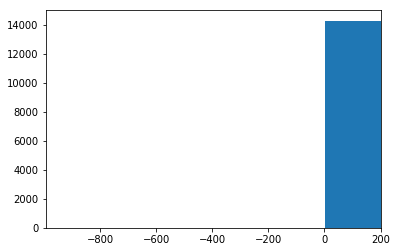

In [12]:
import matplotlib.pyplot as plt
df2 = df.groupby("item_id", as_index=False).item_cnt_day.sum()
plt.hist(df2.item_cnt_day, bins=100)
plt.xlim(xmax=200)
plt.show()

In [13]:
print(df2[df2.item_cnt_day > 200].shape)
print(df2.shape)

(135, 2)
(14416, 2)


**Note:**

- It will be necessary to had the category it the table which corespond to each item
- As we need to predict the total number of sale for the whole November month we will need to refactor the train dataset to have for each day the number of sales in the previous rolling month.
- We will also need to predict one month ahead and not one day ahead.

In [24]:
raw_train_dataset.shape

(2935849, 6)

In [16]:
raw_train_dataset[raw_train_dataset.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [21]:
print(raw_train_dataset[raw_train_dataset.item_cnt_day < 0].shape)
raw_train_dataset[raw_train_dataset.item_cnt_day < 0].head()

(7356, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0


In [23]:
print(raw_train_dataset[raw_train_dataset.item_cnt_day < -1].shape)
raw_train_dataset[raw_train_dataset.item_cnt_day < -1].head()

(104, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
59155,10.01.2013,0,12,1590,2599.0,-5.0
59156,18.01.2013,0,12,1590,2599.0,-6.0
59161,18.01.2013,0,12,1593,1799.0,-3.0
59162,26.01.2013,0,12,1593,1799.0,-2.0
79029,03.01.2013,0,59,14931,699.0,-2.0


In [22]:
print(raw_train_dataset[raw_train_dataset.item_cnt_day == 0].shape)
raw_train_dataset[raw_train_dataset.item_cnt_day == 0].head()

(0, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Quick look at the test dataset

In [7]:
raw_test_dataset = pd.read_csv(TEST_DATASET_FILE)
print(raw_test_dataset.shape)
raw_test_dataset.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [15]:
sample_submission = pd.read_csv(SAMPLE_SUB_FILE)
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


**Note:**

As it is a time serie preidction problem and the test set is set for 1 month we will use the month of October 2015 as dev set. We will use a subset of the item as validation set to train the model for real prediction wich will be done it two steps.

### Quick look at the shop table

In [10]:
shop_informations_dataframe = pd.read_csv(SHOP_INFO_FILE)
print(shop_informations_dataframe.shape)
shop_informations_dataframe.head()

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### Quick look at the item table

In [11]:
item_informations_dataframe = pd.read_csv(ITEM_INFO_FILE)
print(item_informations_dataframe.shape)
item_informations_dataframe.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


### Quick look at the item category table

In [12]:
item_category_informations_dataframe = pd.read_csv(ITEM_CAT_INFO_FILE)
print(item_category_informations_dataframe.shape)
item_category_informations_dataframe.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


**Note**:
- I would be intersting to translate the name of the product categories but not of the prudct and the shop as it is either undoable or irelevante.
- It would be intersting to do some clustering on the shops and the products categories in order to rediuce the dimession of this categorial data.